# Insikter från budgetdata

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%config InlineBackend.figure_format = 'retina'

## Setup

In [30]:
plt.rcParams['font.weight'] = 500
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 500
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelcolor'] = '#606062'

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.color'] = '#e1e1e1'
plt.rcParams['axes.formatter.use_locale'] = True
plt.rcParams['axes.labelweight'] = 500

plt.rcParams['xtick.color'] = '#606062'
plt.rcParams['ytick.color'] = '#606062'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.pad'] = 4
plt.rcParams['ytick.major.pad'] = 16
plt.rcParams['ytick.minor.pad'] = 16
plt.rcParams['ytick.major.size'] = 0
plt.rcParams['xtick.labelsize']	= 14
plt.rcParams['ytick.labelsize']	= 14

plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [22]:
opposition_parties = ['c', 'kd', 'l', 'm', 'sd', 'v']
data_path = '../data'
frames = []

for party in opposition_parties:
    frame = pd.read_csv(f'{data_path}/budgetmotion-2022-{party}.csv', dtype=str)
    frame['Parti'] = party.upper()
    frames.append(frame)

In [23]:
df = pd.concat(frames, sort=False)

In [24]:
df['Utgiftsområde'] = df['Utgiftsområde'].astype(int)
df['2022'] = df['2022'].astype(int)
df['2023'] = df['2023'].astype(float).astype('Int64')
df['2024'] = df['2024'].astype(float).astype('Int64')

In [25]:
gov = pd.read_csv('../data/budgetproposition-2022-regering.csv', dtype=str)
gov['Utgiftsområde'] = gov['Utgiftsområde'].astype(int)
gov['2022'] = gov['2022'].astype(int)

# Standardize identifiers
gov['Anslag'] = gov['Underområde'] + ':' + gov['Anslag']

In [26]:
df = df.drop('Namn', axis=1)
gov = gov.drop('Underområde', axis=1)
gov['Parti'] = 'Regeringen'
gov = gov.dropna(subset=['Anslag'])
df = pd.concat([df, gov.drop('Namn', axis=1)], sort=False)
df = df.melt(id_vars=['Utgiftsområde', 'Anslag', 'Parti'], var_name='År', value_name='Summa')
df = df.pivot_table(index=['Utgiftsområde', 'Anslag', 'År'], columns='Parti', values='Summa')
df = df / 1_000_000
df = df.fillna(0)

## Hur ofta är de överens?

In [27]:
d = df.reset_index().copy()
d = d[~d.Anslag.str.startswith('99')]
d = d[d.År == '2022']
d = ((d.set_index(['Utgiftsområde', 'Anslag', 'År']) == 0).mean() * 100).round().sort_values()
d = d.drop('Regeringen')

In [28]:
colors = {
    'C': '#1A4234',
    'KD': '#005EA1',
    'L': '#4DC5EE',
    'M': '#2975E9',
    'SD': '#F0C244',
    'V': '#A92422',
}

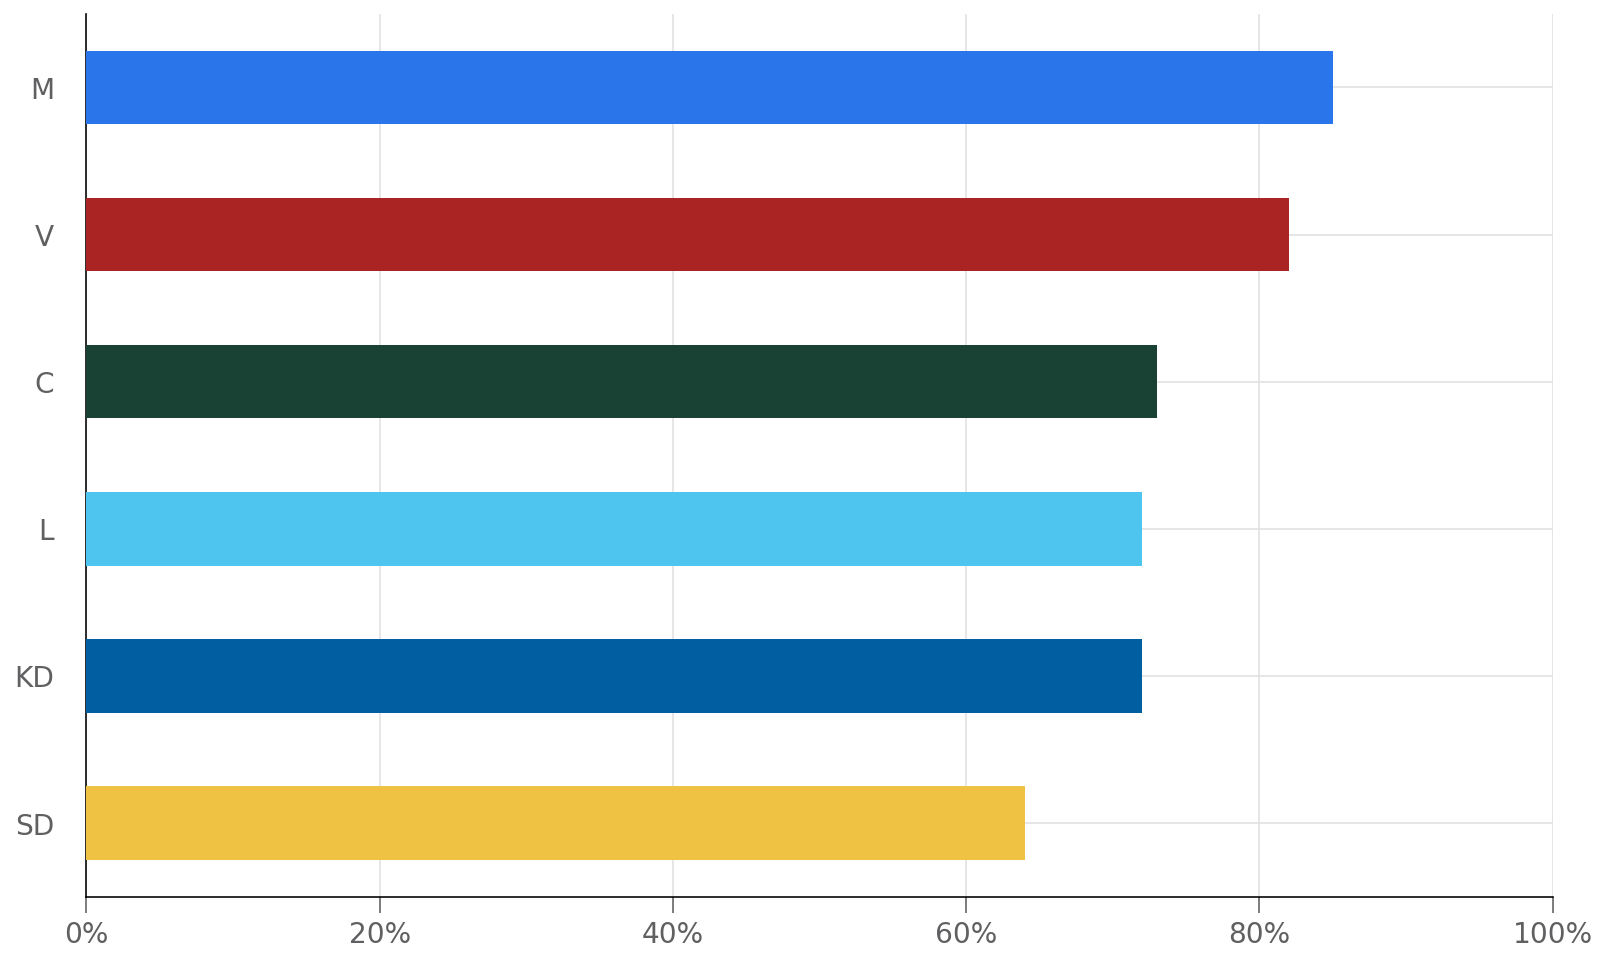

In [29]:
ax = d.plot.barh(figsize=(11.52, 6.88), xlim=(0, 100), grid=True,
                 color=d.index.map(colors), zorder=100, ylabel=False)

plt.tight_layout(pad=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.label.set_visible(False)

## Hur skiljer sig budgetarna i storlek?

In [11]:
sums = pd.read_csv('../data/budgetmotion-2022-summor.csv')

In [12]:
sums = sums.groupby('Parti')['2022'].sum()
sums = sums / 1_000_000_000

In [13]:
sums = sums.sort_values()

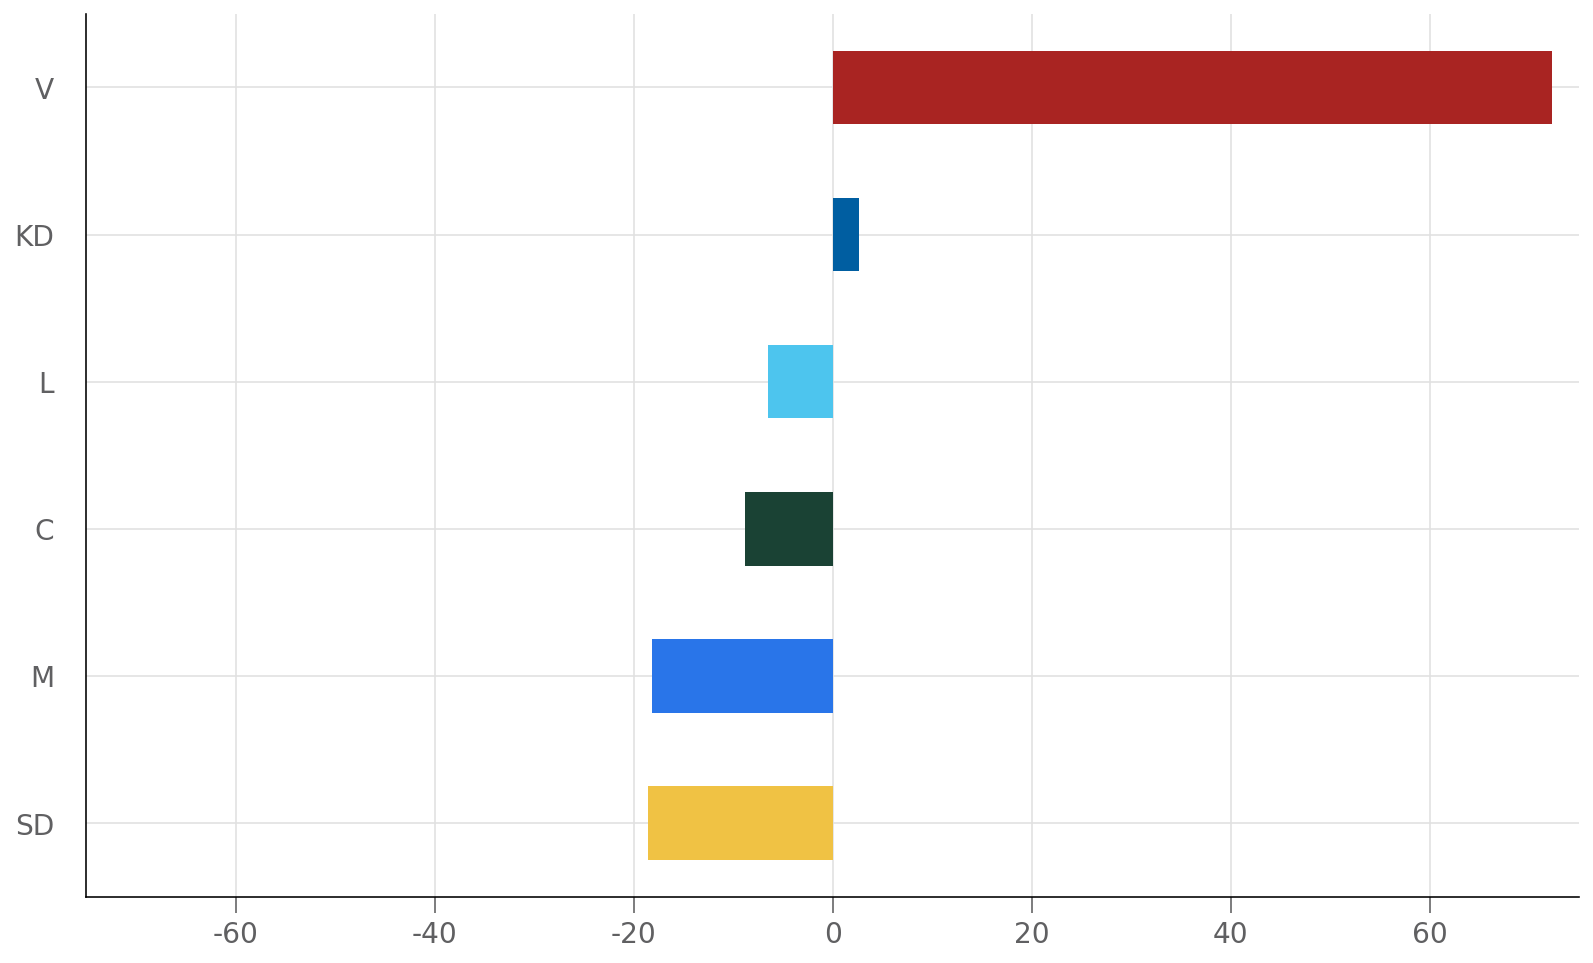

In [17]:
ax = sums.plot.barh(figsize=(11.52, 6.88),
                    grid=True,
                    color=sums.index.map(colors),
                    zorder=100,
                    xlim=(-75, 75),
                    ylabel=False)

ff = plt.FuncFormatter(lambda x, _: "{:,}".format(int(x)).replace(',', ' '))
ax.get_xaxis().set_major_formatter(ff)
plt.tight_layout(pad=1)

ax.yaxis.label.set_visible(False)

## Vilka områden vill partierna öka/minska mest?

In [62]:
d = df.reset_index(level=2).merge(gov[['Utgiftsområde', 'Anslag', 'Namn']],
                              left_index=True,
                              right_on=['Utgiftsområde', 'Anslag'], how='left')
d = d[d.År == '2022']

In [63]:
for party in opposition_parties:
    d[f'{party.upper()}_prc'] = d[party.upper()] / d.Regeringen * 100

In [74]:
d.sort_values('KD')

,År,C,KD,L,M,Regeringen,SD,V,Utgiftsområde,Anslag,Namn,C_prc,KD_prc,L_prc,M_prc,SD_prc,V_prc
211,2022,-3254.0,-4237.0,-308.0,-4524.0,42743.597,-20.0,1528.0,14,1:2,Bidrag till arbetslöshetsersättning och aktivi...,-7.612836,-9.912596,-0.720576,-10.584041,-0.046791,3.574804
453,2022,-1705.0,-2676.0,0.0,-2005.0,3725.500,-2005.0,0.0,20,1:14,Skydd av värdefull natur,-45.765669,-71.829285,0.000000,-53.818279,-53.818279,0.000000
165,2022,-1284.0,-2637.4,-8990.0,-2722.0,41005.070,-30.0,-360.0,10,1:1,Sjukpenning och rehabilitering m.m.,-3.131320,-6.431888,-21.924118,-6.638204,-0.073162,-0.877940
186,2022,-3194.0,-2412.0,-3194.0,-3194.0,48225.247,-1699.0,-110.0,12,1:2,Föräldraförsäkring,-6.623087,-5.001530,-6.623087,-6.623087,-3.523051,-0.228096
425,2022,-1505.0,-1365.0,-1565.0,-1256.0,1565.000,-1565.0,1000.0,18,1:7,Energieffektivisering av flerbostadshus,-96.166134,-87.220447,-100.000000,-80.255591,-100.000000,63.897764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,2022,321.0,1315.0,400.0,863.0,32985.967,3145.0,70.0,4,1:1,Polismyndigheten,0.973141,3.986544,1.212637,2.616264,9.534357,0.212211
132,2022,1430.0,1650.0,-1700.0,80.0,24868.886,515.0,4520.0,9,1:6,Bidrag till folkhälsa och sjukvård,5.750157,6.634797,-6.835851,0.321687,2.070861,18.175322
153,2022,-650.0,1750.0,245.0,0.0,8660.490,200.0,0.0,9,4:5,Stimulansbidrag och åtgärder inom äldreområdet,-7.505349,20.206709,2.828939,0.000000,2.309338,0.000000
222,2022,1306.0,3084.0,650.0,1628.0,4771.685,-2400.0,0.0,14,1:13,"Nystartsjobb, etableringsjobb och stöd för yrk...",27.369787,64.631257,13.622022,34.117927,-50.296698,0.000000
